In [199]:
import load_data
import os
import pandas as pd
import numpy as np
import sklearn.linear_model
import sklearn.ensemble
import matplotlib.pyplot as plt
import seaborn as sns
import plot
import time
import datetime
import numpy as np

allDf = load_data.getPandasDataframes()

bejAirDf = allDf[('Beijing', 'air')]
bejMetDf = allDf[('Beijing', 'met')]
bejGrd = allDf[('Beijing', 'grid')]

bejAirDf['newTime'] = pd.to_datetime(bejAirDf['time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
bejMetDf['time'] = pd.to_datetime(bejMetDf['time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
bejGrd['time'] = pd.to_datetime(bejGrd['time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

bejMetDf = bejMetDf.rename(columns={'station_id':'met_station'})
bejGrd = bejGrd.rename(columns={'station_id':'met_station'})

bejDf = pd.DataFrame()
for key in ['station_id', 'PM25_Concentration', 'PM10_Concentration', 'NO2_Concentration', 'CO_Concentration', 'O3_Concentration', 'SO2_Concentration']:
    bejDf[key] = bejAirDf[key]
bejDf['time'] = bejAirDf['newTime']

bejDf['hour'] = bejAirDf['newTime'].dt.hour
#bejDf['minute'] = bejAirDf['newTime'].dt.minute
#bejDf['second'] = bejAirDf['newTime'].dt.second
bejDf['day'] = bejAirDf['newTime'].dt.day
bejDf['month'] = bejAirDf['newTime'].dt.month
#bejDf['year'] = bejAirDf['newTime'].dt.year
bejDf['dayofweek'] = bejAirDf['newTime'].dt.dayofweek
bejDf['dayofweek'] = pd.Categorical(bejDf['dayofweek'], ordered=False)

valueDict = {(row['station_id'],row['time'].to_pydatetime()):row['PM10_Concentration'] for index, row in bejDf.iterrows()}
bejDf['PM10_3'] = bejDf['PM10_Concentration']
bejDf['PM10_3B'] = bejDf['PM10_Concentration']
bejDf['PM10_3C'] = bejDf['PM10_Concentration']
for index, row in bejDf.iterrows():
    rtime = row['time'].to_pydatetime()
    rtime = rtime - datetime.timedelta(hours=1)
    rtime2 = rtime - datetime.timedelta(hours=1)
    rtime3 = rtime2 - datetime.timedelta(hours=1)
    bejDf.at[index, 'PM10_3'] = valueDict.get((row['station_id'], rtime), np.NaN)
    bejDf.at[index, 'PM10_3B'] = valueDict.get((row['station_id'], rtime2), np.NaN)
    bejDf.at[index, 'PM10_3C'] = valueDict.get((row['station_id'], rtime3), np.NaN)


#stationDf = bejDf[bejDf['station_id']=='tiantan_aq']
#ToDo: limit to one station for now
#bejDf = stationDf

if False:
    plt.scatter(x=bejDf.PM25_Concentration, y=bejDf.PM10_Concentration)
    plt.xlabel("time", fontsize=14)
    plt.ylabel("PM10_Concentration", fontsize=14)
    f = plt.gcf()
    f.set_figheight(10)
    f.set_figwidth(15)
    plt.show()
    
# bejDf = bejDf.fillna(bejDf.median())
# bejDf = pd.get_dummies(bejDf, 'dum')


https://biendata.com/competition/airquality/bj/2017-01-01-0/2018-05-31-23/2k0d1d8
data/Beijing/air/bj_airquality_2017-01-01-0_2018-05-31-23.csv

https://biendata.com/competition/meteorology/bj/2017-01-01-0/2018-05-31-23/2k0d1d8
data/Beijing/met/bj_meteorology_2017-01-01-0_2018-05-31-23.csv

https://biendata.com/competition/meteorology/bj_grid/2017-01-01-0/2018-05-31-23/2k0d1d8
data/Beijing/grid/bj_grid_2017-01-01-0_2018-05-31-23.csv

https://biendata.com/competition/airquality/ld/2017-01-01-0/2018-05-31-23/2k0d1d8
data/London/air/ld_airquality_2017-01-01-0_2018-05-31-23.csv

https://biendata.com/competition/meteorology/ld/2017-01-01-0/2018-05-31-23/2k0d1d8
data/London/met/ld_meteorology_2017-01-01-0_2018-05-31-23.csv

https://biendata.com/competition/meteorology/ld_grid/2017-01-01-0/2018-05-31-23/2k0d1d8
data/London/grid/ld_grid_2017-01-01-0_2018-05-31-23.csv



In [200]:
# bejDf['businessHours'] = 0
# bejDf[(bejDf['hour'] >= 8) & (bejDf['hour']<=18)]['businessHours'] = 1
# bejDf.loc[workIndex,:]['businessHours'] = 1
# bejDf.head(n=100)

In [201]:
bj1718meo = pd.read_csv('viz/stash/beijing_17_18_meo.csv')
bj1718meo = bj1718meo.rename(columns={'station_id':'met_station'})
bj_meo_stations = pd.read_csv('viz/stash/Beijing_meo_stations.csv')
bj_ring = pd.read_csv('viz/stash/Beijing_Neighbors.csv')
bj_nn = pd.read_excel('viz/stash/Beijing_Neighbors.xlsx')
bj_nn = bj_nn.rename(columns={"aq_station": "station_id"})

In [202]:
bj_nn[bj_nn['met_station']=='fangshan_met'] =  'fangshan_meo'

In [203]:
temp = bejDf.merge(bj_nn, on='station_id', how='left')
bejWeather = pd.concat([bejMetDf, bejGrd])
temp = pd.merge(temp, bejWeather,  how='left', on=['met_station','time'])
temp = temp.drop(columns='id')
temp.head()

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


,station_id,PM25_Concentration,PM10_Concentration,NO2_Concentration,CO_Concentration,O3_Concentration,SO2_Concentration,time,hour,day,...,PM10_3,PM10_3B,PM10_3C,met_station,humidity,pressure,temperature,weather,wind_direction,wind_speed
0,dongsi_aq,105.0,172.0,53.0,0.8,127.0,14.0,2018-03-31 07:00:00,7,31,...,NaN,NaN,NaN,beijing_grid_303,18.0,1006.3160,22.0,PARTLY_CLOUDY_DAY,160.36,10.08
1,tiantan_aq,95.0,123.0,54.0,0.9,121.0,15.0,2018-03-31 07:00:00,7,31,...,NaN,NaN,NaN,beijing_grid_303,18.0,1006.3160,22.0,PARTLY_CLOUDY_DAY,160.36,10.08
2,guanyuan_aq,95.0,139.0,66.0,0.8,123.0,13.0,2018-03-31 07:00:00,7,31,...,NaN,NaN,NaN,beijing_grid_282,18.0,1003.7027,22.0,PARTLY_CLOUDY_DAY,154.71,11.04
3,wanshouxigong_aq,99.0,172.0,58.0,1.0,119.0,14.0,2018-03-31 07:00:00,7,31,...,NaN,NaN,NaN,beijing_grid_303,18.0,1006.3160,22.0,PARTLY_CLOUDY_DAY,160.36,10.08
4,aotizhongxin_aq,117.0,166.0,67.0,0.8,111.0,14.0,2018-03-31 07:00:00,7,31,...,NaN,NaN,NaN,beijing_grid_304,18.0,1004.8189,22.0,PARTLY_CLOUDY_DAY,154.72,10.70


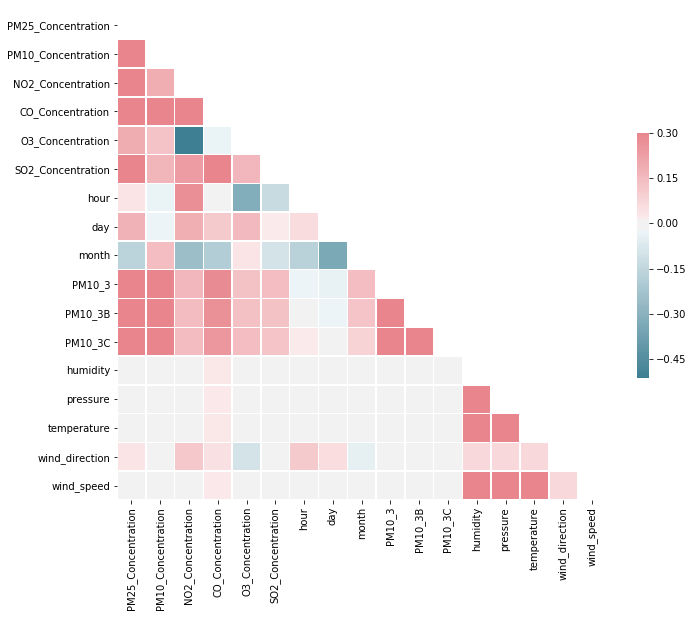

In [217]:

tempNum = temp.select_dtypes('number')
tempNum = tempNum.dropna()
tempCor = tempNum.corr()
mask = np.zeros_like(tempCor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(tempCor, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [542]:
# ct = datetime.datetime.utcnow() - datetime.timedelta(days=2)
# splitDate = pd.datetime(ct.year,ct.month,ct.day,  ct.hour)
# trainDf = bejDf[bejDf['time'] < splitDate]
# testDf = bejDf[bejDf['time'] >= splitDate]

In [543]:
# cur = datetime.datetime.utcnow()
# current_time = pd.datetime(cur.year,cur.month,cur.day,cur.hour)
# d = list(testDf.time)
# date_list = [current_time - datetime.timedelta(hours=x) for x in range(0, 48)]
# date_list = [pd.to_datetime(i, format='%Y-%m-%d %H:%M:%S') for i in date_list]
# missingDatesFromTestDf = np.setdiff1d(sorted(date_list),list(set(sorted(d))))
# list(missingDatesFromTestDf)

[Timestamp('2018-04-28 05:00:00'),
 Timestamp('2018-04-29 00:00:00'),
 Timestamp('2018-04-29 16:00:00'),
 Timestamp('2018-04-29 17:00:00'),
 Timestamp('2018-04-29 23:00:00')]